## Tic-Tac-Toe Numerical - RL Agent Type : EVEN : Agent plays EVEN moves

##### Author : Anugraha Sinha
##### Email : anugraha[dot]sinha[at]gmail[dot]com

In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

##### Submitted by : Anugraha Sinha

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [2]:
import collections
import numpy as np
import random
import pickle
import collections
from matplotlib import pyplot as plt
import time
import os
from datetime import datetime
from itertools import groupby
from itertools import product

Creating a function to convert the [list] structure of states to a string based structure so that it could be added to Q_dict

In [3]:
class TicTacToe():

    def __init__(self):
        """initialise the board"""
        
        # initialise state as an array
        self.state = [np.nan for _ in range(9)]  # initialises the board position, can initialise to an array or matrix
        # all possible numbers
        self.all_possible_numbers = [i for i in range(1, len(self.state) + 1)] # , can initialise to an array or matrix

        self.reset()


    def is_winning(self, curr_state):
        """Takes state as an input and returns whether any row, column or diagonal has winning sum
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan]
        Output = False"""
        
        '''
        Comment from Anugraha Sinha:
        We are visualizing the game in following fashion (The number in boxes are the idx values of "self.states"
         ____________________
        |      |      |      |
        |   0  |   1  |   2  |
        |______|______|______|
        |      |      |      |
        |   3  |   4  |   5  |
        |______|______|______|
        |      |      |      |
        |   6  |   7  |   8  |
        |______|______|______|
        
        We use a strict way of checking the sum as 15, because np.diagonal provides only primary diagonal (top-left -> bottom-right)
        However, we would also want to check (top-right -> bottom-left), hence we do not follow the simple np.sum methods, but define the indexes individually
        '''
        horizontals = [[0,1,2],[3,4,5],[6,7,8]]
        verticals = [[0,3,6],[1,4,7],[2,5,8]]
        diagonals = [[0,4,8],[2,4,6]]
        
        hor_ans = list(filter(lambda x : np.sum(np.array(curr_state)[x]) == 15,horizontals))
        ver_ans = list(filter(lambda x : np.sum(np.array(curr_state)[x]) == 15,verticals))
        diag_ans = list(filter(lambda x : np.sum(np.array(curr_state)[x]) == 15,diagonals))
        
        if len(hor_ans) != 0 or len(ver_ans) != 0 or len(diag_ans) != 0:
            return True
        else:
            return False

    def is_terminal(self, curr_state):
        # Terminal state could be winning state or when the board is filled up

        if self.is_winning(curr_state) == True:
            return True, 'Win'

        elif len(self.allowed_positions(curr_state)) ==0:
            return True, 'Tie'

        else:
            return False, 'Resume'


    def allowed_positions(self, curr_state):
        """Takes state as an input and returns all indexes that are blank"""
        return [i for i, val in enumerate(curr_state) if np.isnan(val)]


    def allowed_values(self, curr_state):
        """Takes the current state as input and returns all possible (unused) values that can be placed on the board"""

        used_values = [val for val in curr_state if not np.isnan(val)]
        
        # Since this agent works on EVEN numbers 
        
        env_values = [val for val in self.all_possible_numbers if val not in used_values and val % 2 !=0]
        agent_values = [val for val in self.all_possible_numbers if val not in used_values and val % 2 ==0]

        return (agent_values, env_values)


    def action_space(self, curr_state):
        """Takes the current state as input and returns all possible actions, i.e, all combinations of allowed positions and allowed values"""

        agent_actions = product(self.allowed_positions(curr_state), self.allowed_values(curr_state)[0])
        env_actions = product(self.allowed_positions(curr_state), self.allowed_values(curr_state)[1])
        return (agent_actions, env_actions)



    def state_transition(self, curr_state, curr_action):
        """Takes current state and action and returns the board position just after agent's move.
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [9, 7]
        Output = [1, 2, 3, 4, nan, nan, nan, 9, nan]
        """
        
        '''
        Comment from Anugraha Sinha:
        As stated in the comment above, we will consider curr_action as a list which means
        curr_action = [position to be added, number to be added]
        
        Note : 
        1. "Position" is in python addressing system
        2. Action space returns (position,number) type of data.
        '''
        new_state = curr_state.copy()                  ## Important : Good if we copy things in order to avoid reference to same memory location #
        new_state[curr_action[0]] = curr_action[1]
        return new_state

    def step(self, curr_state, curr_action):
        """Takes current state and action and returns the next state, reward and whether the state is terminal. Hint: First, check the board position after
        agent's move, whether the game is won/loss/tied. Then incorporate environment's move and again check the board status.
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [9, 7]
        Output = ([1, 2, 3, 4, nan, nan, nan, 9, nan], -1, False)"""
        
        # update state with agent's action #
        new_state = self.state_transition(curr_state,curr_action)
        
        # check the status (win/loss/tie) after agent's move
        chk_terminal,message = self.is_terminal(new_state)
        
        if chk_terminal:
            # If we reached terminal state, display message
            #print("After agent's move, reached terminal state : %s" %(message))
            # If it was win, reward will be '10'
            if message == "Win":
                reward = 10
                msg = "Agent Won"
            # if it was tie, reward will '0'
            else:
                reward = 0
                msg = "Tie"
            return new_state,reward,chk_terminal,msg
        else:
            # It is not a terminal state after agent's move #
            # execute move for environment #
            
            # Environment's next action would be random selection from available action space #
            env_action = random.choice([ac for itr,ac in enumerate(self.action_space(new_state)[1])])
            
            # execute environment action #
            new_state = self.state_transition(new_state,env_action)
            
            # we should check if environment's action resulted in terminal state #
            chk_terminal_2, message_2 = self.is_terminal(new_state)
            
            if chk_terminal_2:
                # if we reached a terminal state #
                #print("After agent's action of : %s, environment took action as : %s. This led to terminal state : %s" %(str(curr_action),str(env_action),message_2))
                # if it was win by environment, then reward should be "-10"
                if message_2 == "Win":
                    reward = -10
                    msg = "Env Won"
                # if it was tie, reward will be '0'
                else:
                    reward = 0
                    msg = "Tie"
                return new_state,reward,chk_terminal_2,msg
            else:
                # even after environment action, we have "resume", and hence reward = "-1"
                reward = -1
                msg = "Continue"
                return new_state, reward, chk_terminal_2,msg
        
    def reset(self):
        return self.state
        
    def print_board(self,curr_state):
        printable_curr_state = ["X" if np.isnan(x) else str(x) for x in curr_state]
        return "    %s\n    %s\n    %s" %(str(np.array(printable_curr_state).reshape(3,3)[0,:]),str(np.array(printable_curr_state).reshape(3,3)[1,:]),str(np.array(printable_curr_state).reshape(3,3)[2,:]))

In [4]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

**valid_actions** provides available action for the *agent* given a state of the game.

In [5]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

**add_to_dict** adds a state in *Q_dict* if it does not exist. 

* Remember, while adding the new state, all valid actions will also be added with a default q_value = 0

In [6]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy

We build an epsilon greedy strategy for controlling exploitation and exploration of the agent.

Description of how epsilon greedy strategy works is provided in comments below.

In [7]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
exploitation = 0
exploration = 0
def select_action_epsilon_greedy(state,time):
    max_epsilon = 1.0
    min_epsilon = 0.001
    chk_epsilon_value = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.00001*time)
    random_value = np.random.random()
    
    # just testing #
    #chk_epsilon_value = -1
    
    # Comment from Anugraha Sinha #
    # As we play more number of games, "time" value will become higher and higher
    # This will lead to have the chk_epsilon_value to become smaller and smaller
    #
    # So as epsilon becomes smaller, we should follow a more "exploitation" strategy
    # When epsilon is higher, we should follow a more "exploration strategy"
    global exploitation
    global exploration
    if random_value > chk_epsilon_value:
        # This means we should follow an "exploitation" strategy
        proposed_action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)
        exploitation += 1
    else:
        # This means we should follow an "exploration" strategy
        proposed_action = random.choice([ac for itr,ac in enumerate(env.action_space(state)[0])])
        exploration += 1
    return proposed_action

Initializing new Q_dict and States_tract

In [34]:
# Initialise Q_dictionary and States_tracked (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

The states chosen for States_action pairs to be tracked is based on the strategy that 5 positions on the board should be empty.

Therefore, we have states which have 5 - "x" value in state's key.

In [9]:
def initialise_tracking_states():
    # Initialise states to be tracked
    # Based on the comment above, we will track following state,action pairs (10 in nos) #
    state_action_pair = [('x-7-3-x-2-8-x-x-x', (0, 1)),
                         ('x-1-2-x-7-x-x-8-x', (0, 3)),
                         ('6-x-2-x-x-3-x-x-1', (1, 5)),
                         ('6-x-7-x-x-1-x-x-4', (1, 3)),
                         ('x-x-x-4-9-2-7-x-x', (0, 1)),
                         ('x-x-3-8-2-x-x-x-5', (0, 1)),
                         ('3-x-7-x-x-x-x-8-2', (1, 5)),
                         ('x-x-1-8-2-7-x-x-x', (0, 3)),
                         ('x-1-x-x-x-x-8-6-7', (0, 3)),
                         ('x-9-x-x-6-8-x-x-5', (0, 1))]
    for st,ac in state_action_pair:
        States_track[st][ac] = list()

A standard function to save objs as pickle files.

In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

##### save_tracking_states
we will execute this function after a few games have been played to store the change in q_values of the chosen state action pairs which are being tracked.

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

Initializing tracking states so that we can save the data.

In [12]:
initialise_tracking_states()

#### Define hyperparameters  (Exec 1)
In this execution we do following
* 5 million games to be played
* Learning Rate : 0.01
* Discount Factor : 0.91
* Policy (Q_dict) : To be saved every 20000th game
* Saved tracking states : To be saved every 20000th game
* Success Values : Games won/lost/tie(s) to printed at every 10000th game.

In [21]:
EPISODES = 5000000
LR=0.09
GAMMA = 0.99
policy_threshold = 20000
save_tracking_state_threshold = 20000
episode_print_threshhold = 10000

### Q-update loop (Exec1)

In [35]:
start_time = time.time()

dir_to_save = "./TicTacTor_Q_Value_Model_" + datetime.now().strftime("%Y%m%d_%H%M%S")
if not os.path.exists(dir_to_save):
    os.mkdir(dir_to_save)
    
agent_won_count = 0
agent_won_list = list()
env_won_count = 0
env_won_list = list()
tie_count = 0
tie_list = list()

total_reward = 0

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    # Build a new environment for this episode #
    env = TicTacToe()
    current_state = env.state
    
    # Since in this case, env has odd values, hence for every episode, env should execute an action first
    env_action_1 = random.choice([ac for itr,ac in enumerate(env.action_space(current_state)[1])])
    
    current_state = env.state_transition(current_state,env_action_1)
    
    add_to_dict(current_state)
    
    # Since this an episodic task, therefore it will end at sometime
    # Hence we keep running and dont need to have a step calculating approach #
    
    stop_running = False
    while not stop_running:
        # get action as per epsilon strategy #
        # Remember, for 1 game we follow same strategy, however, next game we evolve our strategy.
        # Therefore for "select_action_epsilon_greedy", 2nd argument will be episode
        #print("Before : \n%s" %(env.print_board(current_state)))
        agent_action = select_action_epsilon_greedy(current_state,episode)
        #print("Agent action = %s" %(str(agent_action)))
        
        # execute the action #
        next_state, reward, stop_running, msg = env.step(current_state,agent_action)
        #print("After : \n%s" %(env.print_board(next_state)))
        
        # add the next state to the Q_dict, as this may be an entirely new state not seen before #
        # Also it may be that the next state is a terminal state, even then we add it to Q_dict
        # although we will never update the q_values for this (also given in question)
            
        add_to_dict(next_state)
        
        # save the reward #
        
        # if the next state is a terminal state, record the game status (won/lost/tie)
        # also remember that the next state (terminal states) q_value will be zero (0).
        # Update in Q_values of current_state,action should be taken care appropriately.
        if stop_running:
            # terminal state - either a tie or a win by agent or environment
            if msg == "Agent Won":
                agent_won_count += 1
            elif msg == "Env Won":
                env_won_count += 1
            else:
                tie_count += 1
            best_next_action = None
            # Remember in this case, the Q_value for next state will be 0, hence we do (reward + GAMMA* 0)
            Q_dict[Q_state(current_state)][agent_action] += LR * ((reward + (GAMMA*0)) - Q_dict[Q_state(current_state)][agent_action]) 
        else:
            # we update the current_state,agent_action reward based on "BEST" action possible for the next state #
            # we get the BEST ACTION for next_state and use that with the discount factor #
            best_next_action = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)
            Q_dict[Q_state(current_state)][agent_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][best_next_action]))) - Q_dict[Q_state(current_state)][agent_action] ) 
    
        current_state = next_state
    
    agent_won_list.append(agent_won_count)
    env_won_list.append(env_won_count)
    tie_list.append(tie_count)
    
    if (episode + 1) % episode_print_threshhold == 0:
        print("After playing %d games, Agent Won : %.4f, Environment Won : %.4f, Tie(s) : %.4f" %(episode+1,agent_won_count/(episode+1),env_won_count/(episode+1),tie_count/(episode+1)))
    
    # If this is EPISODE is at threshold multiples, we will update the States_track for checking convergence
    if (episode + 1) % save_tracking_state_threshold == 0:
        save_tracking_states()
        #save_tracking_states_file = dir_to_save + "/Saved_tracking_states_itr_" + str(episode) + ".pickle"
        #save_obj(States_track,save_tracking_states_file)
        
    # If this EPISODE is at policy_threshold multiples, then we would save the policy model
    #if (episode + 1) % policy_threshold == 0:
        #q_value_policy_name = dir_to_save + "/Q_value_model_itr_" + str(episode) + ".pickle"
        #save_obj(Q_dict,q_value_policy_name)
        
elapsed_time = time.time() - start_time
print("Elapsed time :",elapsed_time)

After playing 10 games, Agent Won : 0.2000, Environment Won : 0.6000, Tie(s) : 0.2000
After playing 20 games, Agent Won : 0.3000, Environment Won : 0.5000, Tie(s) : 0.2000
After playing 30 games, Agent Won : 0.2667, Environment Won : 0.4000, Tie(s) : 0.3333
After playing 40 games, Agent Won : 0.2750, Environment Won : 0.3500, Tie(s) : 0.3750
After playing 50 games, Agent Won : 0.2600, Environment Won : 0.3800, Tie(s) : 0.3600
After playing 60 games, Agent Won : 0.2667, Environment Won : 0.3500, Tie(s) : 0.3833
After playing 70 games, Agent Won : 0.2714, Environment Won : 0.3000, Tie(s) : 0.4286
After playing 80 games, Agent Won : 0.3000, Environment Won : 0.2750, Tie(s) : 0.4250
After playing 90 games, Agent Won : 0.3111, Environment Won : 0.2667, Tie(s) : 0.4222
After playing 100 games, Agent Won : 0.3000, Environment Won : 0.2600, Tie(s) : 0.4400
After playing 110 games, Agent Won : 0.2909, Environment Won : 0.2727, Tie(s) : 0.4364
After playing 120 games, Agent Won : 0.3000, Environ

In [36]:
len(Q_dict.keys())

27159

In [36]:
save_obj(States_track,dir_to_save + '/States_tracked_final.pickle')
save_obj(Q_dict,dir_to_save + '/Policy_final.pickle')

In [35]:
save_obj(agent_won_list,dir_to_save + "/agent_won_list.pickle")
save_obj(env_won_list,dir_to_save + "/env_won_list.pickle")
save_obj(tie_list,dir_to_save + "/game_tie_list.pickle")

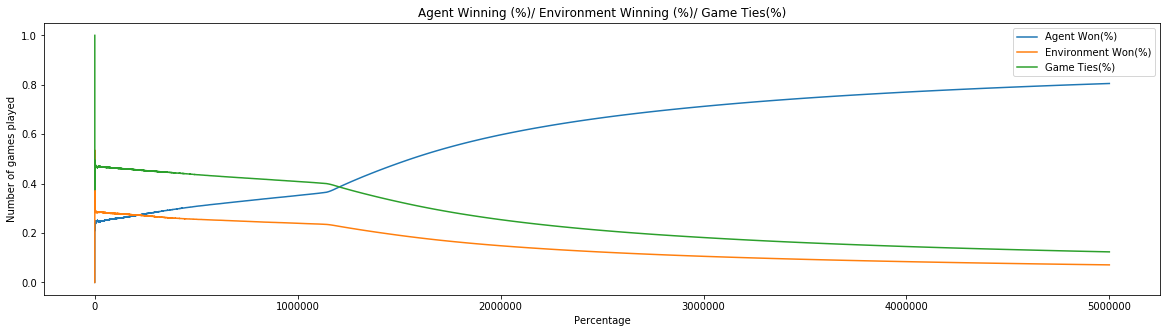

In [30]:
plt.figure(figsize=(20,5))
plt.plot(range(0,5000000),np.array(agent_won_list)/np.array(list(range(1,5000001))))
plt.plot(range(0,5000000),np.array(env_won_list)/np.array(list(range(1,5000001))))
plt.plot(range(0,5000000),np.array(tie_list)/np.array(list(range(1,5000001))))
plt.xlabel("Percentage")
plt.ylabel("Number of games played")
plt.title("Agent Winning (%)/ Environment Winning (%)/ Game Ties(%)")
plt.legend(["Agent Won(%)","Environment Won(%)","Game Ties(%)"],loc="upper right")
plt.show()

Checking convergence of state values for saved_tracking states

**Important**

We present the convergence graph of only 1 state+action pair below, similar to below, we can plot covergence graph for other state+action pairs also.

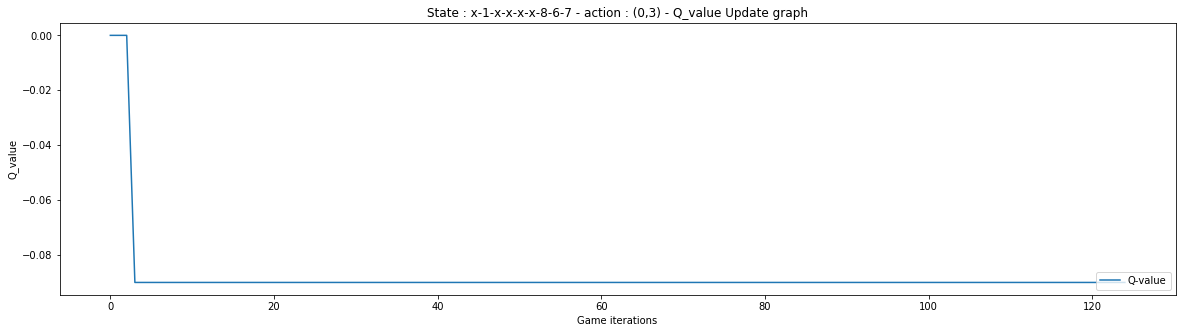

In [57]:
# check saved saved_states for convergence #
plt.figure(figsize=(20,5))
plt.plot(range(0,125),States_track['x-1-x-x-x-x-8-6-7'][(0,3)])
plt.xlabel("Game iterations")
plt.ylabel("Q_value")
plt.title("State : x-1-x-x-x-x-8-6-7 - action : (0,3) - Q_value Update graph")
plt.legend(["Q-value"],loc="lower right")
plt.show()